# EDA: first approach

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [2]:
db = global_connect()
run_query("""SELECT COUNT(1) FROM itineraries""")

,count
0,33415


In [3]:
# Help on remembering itineraries columns
df = careful_query('select * from itineraries limit 1')
df.columns

Index(['itinerary_id', 'driver_id', 'created', 'accepted', 'dropped',
       'started', 'finished', 'status', 'total_distance', 'transport_type',
       'product', 'product_version', 'distribution_center1', 'packages',
       'delivered_packages', 'checked_in_at', 'pickup_checkout_at',
       'pickup_lat', 'pickup_lng', 'real_completion_time', 'pickup_distance',
       'pickup_time', 'check_in_time', 'waypoints'],
      dtype='object')

## Retrieving daily number of itineraries per day

In [4]:
df_it = careful_query("""
SELECT DATE(created), distribution_center1 as agency, COUNT(1) as itineraries,
        SUM(CASE WHEN status = 'finished' THEN 1 ELSE 0	END) as finished,
        SUM(CASE WHEN status != 'finished' THEN 1 ELSE 0 END) as not_finished,
        SUM(CASE WHEN status = 'dropped' THEN 1 ELSE 0 END) as dropped,
        SUM(CASE WHEN status = 'cancelled' THEN 1 ELSE 0 END) as cancelled,
        SUM(CASE WHEN status = 'cancelledWithCharge' THEN 1 ELSE 0 END) as cancelled_wc
FROM ITINERARIES
GROUP BY distribution_center1, DATE(created)
ORDER BY DATE(created)
""")
df_it

,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc
0,2019-10-01,1,52,52,0,0,0,0
1,2019-10-02,1,67,67,0,0,0,0
2,2019-10-03,1,121,121,0,0,0,0
3,2019-10-04,1,43,43,0,0,0,0
4,2019-10-07,1,164,159,5,2,3,0
...,...,...,...,...,...,...,...,...
208,2020-03-10,1,142,135,7,0,6,0
209,2020-03-11,1,199,197,2,0,2,0
210,2020-03-11,2,175,167,8,0,5,0
211,2020-03-12,1,159,149,10,0,2,0


In [5]:
df_it.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          213 non-null    object
 1   agency        213 non-null    int64 
 2   itineraries   213 non-null    int64 
 3   finished      213 non-null    int64 
 4   not_finished  213 non-null    int64 
 5   dropped       213 non-null    int64 
 6   cancelled     213 non-null    int64 
 7   cancelled_wc  213 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 13.4+ KB


## First some global descriptive statistics

In [6]:
df_it.describe()

,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.352113,156.877934,137.014085,19.863850,10.441315,6.615023,0.244131
std,0.478754,65.709223,49.986270,29.989232,24.406398,8.389805,0.904144
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,121.000000,106.000000,4.000000,0.000000,2.000000,0.000000
50%,1.000000,157.000000,141.000000,10.000000,1.000000,4.000000,0.000000
75%,2.000000,197.000000,173.000000,24.000000,9.000000,8.000000,0.000000
max,2.000000,446.000000,238.000000,248.000000,219.000000,67.000000,6.000000


The table above shows very interesting values.
- number of itineraries shows similar mean and median values. Possible normal distribution.
- finished shows similar mean and median values. Possible normal distribution.
- At least the was a day where just one itinerary occurred :S
- At least the was a day where no itinerary was finished :S
- max(dropped) is 219 when its mean is 10 and std is 24. Looks like an outlier.  
  May be the Loggi's system went down once. If this happened and we suspect that  
  the failure is not related with the number of itineraries, then we should eliminate the outlier.
- The median for dropped is 1. This looks like a good service when the itineraries media is 157,  
  but mean is 10 and percentile(75) is 9. Possible skewed distribution.  
  I think we could use the dropped to score day service. 
- max(cancelled) looks like an outlier.
- cancelled with charge is not significant. We could merge its values with cancelled ones.

## Both agencies in a plot

In [7]:
df_it['date'] = pd.to_datetime(df_it['date'])

# dataframe for agency 1
df_a1 = df_it[df_it.agency == 1].copy()
df_a1.set_index(df_a1['date'], inplace=True)

# dataframe for agency 2
df_a2 = df_it[df_it.agency == 2].copy()
df_a2.set_index(df_a2['date'], inplace=True)

idx = pd.DatetimeIndex(pd.date_range(df_it['date'].min(), df_it['date'].max()))
# reindex both dataframe so we can compare them in the same plot
df_a1.reindex(idx, fill_value='NaN');
df_a2.reindex(idx, fill_value='NaN');

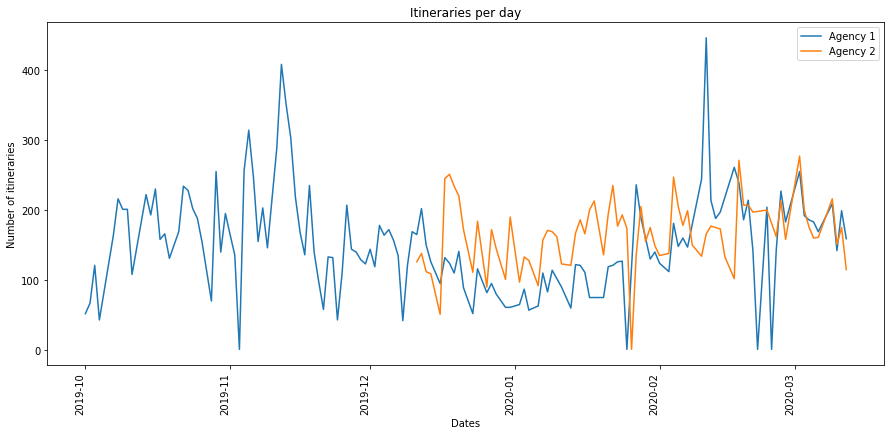

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
df_a1['itineraries'].plot(ax=ax, label='Agency 1')
df_a2['itineraries'].plot(ax=ax, label='Agency 2')
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Number of itineraries')
plt.title('Itineraries per day')
plt.xticks(rotation=90);

**In the above plot we observe:**
- Agency 2 has no data in october and november. Maybe it opened its door later.
- Agency 2 started with more number of itineraries than agency 2, but then both curves become similar in most of the days.
- Agency 1 shows positive and negative peaks:
  . May be the first positive peak made Loggi to decide opening another agency
  . May be the positive peaks corresponds to festive days.
  . The negative peaks could be related to system failures. Loggi is a start up probably in Beta mode.
  . But agency 2 does not present a negative peak in comparison with last two negative peaks of agency 1.
- Both agencies present a pattern probably associated to week behaviour.

In [9]:
pd.concat([df_a1['date'].describe(), df_a2['date'].describe()], axis=1).iloc[[0,1,4,5],:]

,date,date
count,138,75
unique,138,75
first,2019-10-01 00:00:00,2019-12-11 00:00:00
last,2020-03-12 00:00:00,2020-03-12 00:00:00


- agency 1 range from: **2019-10-01** to **2020-03-12**
- agency 2 range from: **2019-12-11** to **2020-03-12**

Maybe the agency 2 opened its door later

In [10]:
print('{:*^60}'.format(' Agency 1 two positive peaks '))
print(df_a1['itineraries'].sort_values(ascending=False)[0:2])
print('{:*^60}'.format(' Agency 1 four negative peaks '))
print(df_a1['itineraries'].sort_values(ascending=True)[0:4])

print('{:*^60}'.format(' Agency 2 first negative peak '))
print(df_a2['itineraries'].sort_values(ascending=True)[0:1])

*************** Agency 1 two positive peaks ****************
date
2020-02-11    446
2019-11-12    408
Name: itineraries, dtype: int64
*************** Agency 1 four negative peaks ***************
date
2019-11-03    1
2020-02-25    1
2020-02-22    1
2020-01-25    1
Name: itineraries, dtype: int64
*************** Agency 2 first negative peak ***************
date
2020-01-26    1
Name: itineraries, dtype: int64


**[TODO]**  
We should investigate if the printed above dates were holiday days or something happened in Brasil or Agency's regions. And then think and decide if this dates are predictable or not for model building.

# Agency 1

In [11]:
df_a1.describe()

,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc
count,138.0,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,1.0,152.108696,129.963768,22.144928,11.079710,7.333333,0.376812
std,0.0,73.274674,52.462487,35.085204,28.663174,9.331161,1.102107
min,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,110.250000,95.000000,5.000000,0.000000,2.000000,0.000000
50%,1.0,143.500000,129.000000,11.500000,1.000000,5.000000,0.000000
75%,1.0,194.500000,172.750000,25.750000,7.750000,9.000000,0.000000
max,1.0,446.000000,237.000000,248.000000,219.000000,67.000000,6.000000


**[TODO] Is there any useful insight in the above descriptive statistics?**  
Lets see the difference with the global descriptive statistics:

In [12]:
(df_a1.describe() - df_it.describe()).iloc[[1,2,5]]

,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc
mean,-0.352113,-4.769239,-7.050316,2.281078,0.638396,0.718310,0.132680
std,-0.478754,7.565451,2.476217,5.095972,4.256776,0.941356,0.197963
50%,0.000000,-13.500000,-12.000000,1.500000,0.000000,1.000000,0.000000


Lookint at the difference values looks like the agency presents a worse performance:
- mean difference: less itineraries, less finished itineraries, more dropped, more cancelled
- std difference: all possitives when mean negative, so agency 1 deviations are greater than global.  

Agency 1 looks more volatile. If we build a good model for agency 1 then we could build a better model for agency 2.

## Agency 1 Plots

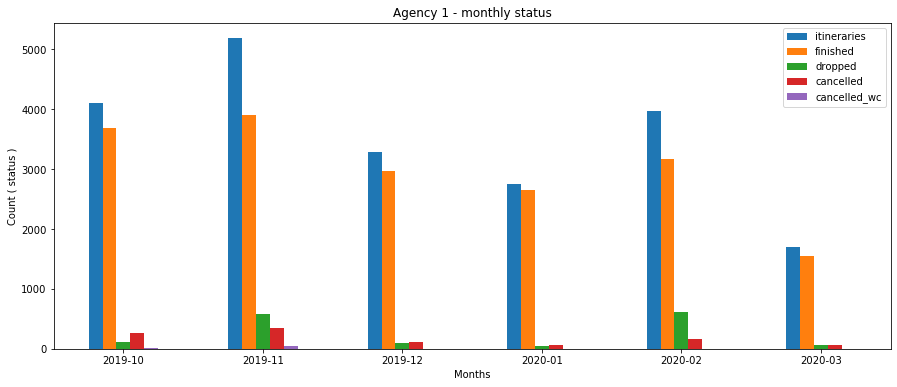

In [13]:
status = ['itineraries', 'finished', 'dropped', 'cancelled', 'cancelled_wc']
fig, ax = plt.subplots(figsize=(15,6))
df_a1.groupby(df_a1.index.to_period('M'))[status].sum().plot.bar(ax=ax)
plt.legend()
plt.xlabel('Months')
plt.ylabel('Count ( status )')
plt.title('Agency 1 - monthly status');
plt.xticks(rotation=0);

Looks like cancelled with charge is only present in october and november. Have Loggi decided to remove charges?

In [14]:
# Let see what was the last date in global itineraries date where an itinerary was cancelled with charges:
df_it[df_it.cancelled_wc > 0]['date'].max()

Timestamp('2019-12-01 00:00:00')

**[TODO]: Ask to Loggi's contact person if the cancelling charge was remove!**

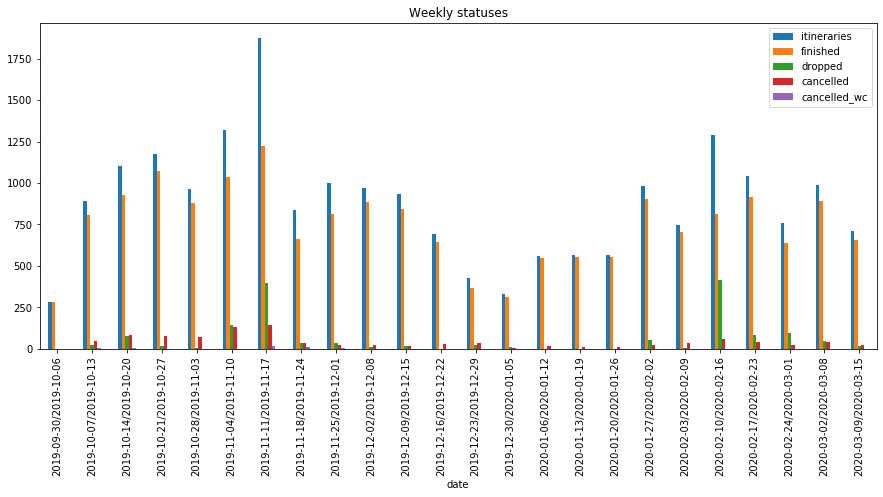

In [15]:
# Weekly status
df_a1.groupby(df_a1.index.to_period('W'))[status].sum().plot.bar(figsize=(15,6));
plt.title('Weekly statuses');

### Let see some ratios

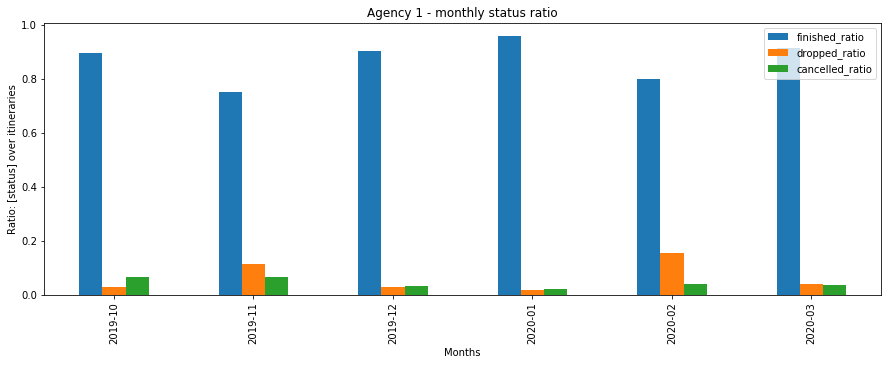

In [16]:
# Monthly ones
df_month = df_a1.groupby(df_a1.index.to_period('M'))[status].sum()
selection = ['finished', 'dropped', 'cancelled']
for col in selection:
    # we know min(itineraries) = 1, so we can do this with no worries
    df_month[col + '_ratio'] = df_month[col] / df_month['itineraries']

ratios = [col + '_ratio' for col in selection]
df_month[ratios].plot.bar(figsize=(15,5));
plt.title('Agency 1 - monthly status ratio');
plt.xlabel('Months')
plt.ylabel('Ratio: [status] over itineraries');
    

This does not look good. The only pattern is that finished ratio is always the winner. But there were no Loggi if this was not true. Dropped ration is higher on november and february months. The agency 1's itineraries peaks were on these months and we know the dates! Probably we are going to find that the agency could not support the increase of itineraries. Increase in itineraries probably means increase in the number of client requests. Or Loggi assigned more itineraries than these that the agency could handle.

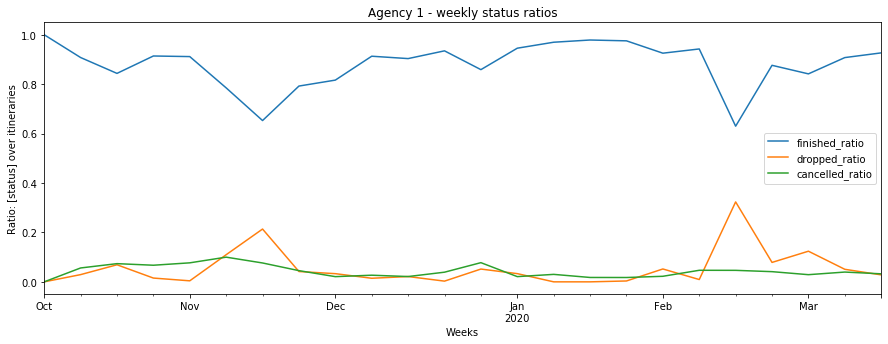

In [17]:
# Weekly ratios
df_weekly = df_a1.groupby(df_a1.index.to_period('W'))[status].sum()
selection = ['finished', 'dropped', 'cancelled']
for col in selection:
    # we know min(itineraries) = 1, so we can do this with no worries
    df_weekly[col + '_ratio'] = df_weekly[col] / df_weekly['itineraries']

ratios = [col + '_ratio' for col in selection]
df_weekly[ratios].plot(figsize=(15,5));
plt.title('Agency 1 - weekly status ratios');
plt.xlabel('Weeks')
plt.ylabel('Ratio: [status] over itineraries');


In [18]:
# Daily ratios
selection = ['finished', 'dropped', 'cancelled']
for col in selection:
    # we know min(itineraries) = 1, so we can do this with no worries
    df_a1[col + '_ratio'] = df_a1[col] / df_a1['itineraries']

ratios = [col + '_ratio' for col in selection]

In [19]:
peaks = df_a1['itineraries'].sort_values(ascending=False)[0:2].index.tolist()
df_a1[df_a1.index.isin(peaks)]

,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc,finished_ratio,dropped_ratio,cancelled_ratio
date,,,,,,,,,,,
2019-11-12,2019-11-12,1,408,203,205,136,67,0,0.497549,0.333333,0.164216
2020-02-11,2020-02-11,1,446,198,248,219,29,0,0.443946,0.491031,0.065022


In the above table we can see:
- numbers of dropped packages were high on these days.
- dropped ratio is high!
- finished ratio is low
- many people cancelled their requests

These were bad days for agency 1!

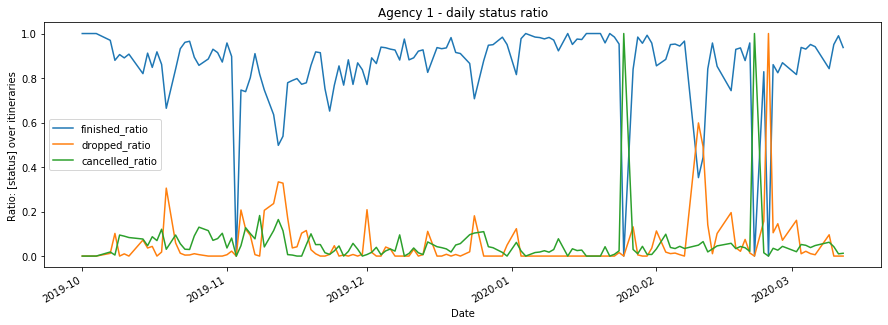

In [20]:
df_a1[ratios].plot(figsize=(15,5));
plt.title('Agency 1 - daily status ratio');
plt.xlabel('Date')
plt.ylabel('Ratio: [status] over itineraries');

**Low number of itineraries makes things look weird**
- [TODO] We need to investigate the dates where this number of low
- We need to see what happens on the rest of the day

In [21]:
df_a1.itineraries.sort_values().head()

date
2019-11-03     1
2020-02-25     1
2020-02-22     1
2020-01-25     1
2019-12-08    42
Name: itineraries, dtype: int64

**[TODO]: Investigate what happened on these four days**

**Re-plot just working days**

In [22]:
working_days = df_a1.itineraries > 1

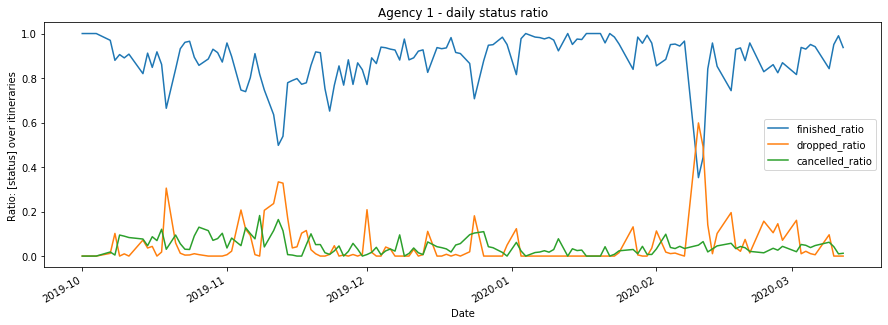

In [23]:
df_a1[working_days][ratios].plot(figsize=(15,5));
plt.title('Agency 1 - daily status ratio');
plt.xlabel('Date')
plt.ylabel('Ratio: [status] over itineraries');

It is clear that there are days bad days. Let looks for patterns

In [24]:
df_a1[(df_a1['dropped_ratio'] > 0.2) & working_days]

,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc,finished_ratio,dropped_ratio,cancelled_ratio
date,,,,,,,,,,,
2019-10-19,2019-10-19,1,131,87,44,40,4,0,0.664122,0.305344,0.030534
2019-11-04,2019-11-04,1,256,191,65,53,12,0,0.746094,0.207031,0.046875
2019-11-09,2019-11-09,1,146,109,37,30,6,0,0.746575,0.205479,0.041096
2019-11-11,2019-11-11,1,288,183,105,68,33,4,0.635417,0.236111,0.114583
2019-11-12,2019-11-12,1,408,203,205,136,67,0,0.497549,0.333333,0.164216
2019-11-13,2019-11-13,1,351,189,162,115,40,6,0.538462,0.327635,0.113960
2019-12-01,2019-12-01,1,144,111,33,30,1,2,0.770833,0.208333,0.006944
2020-02-10,2020-02-10,1,244,86,158,146,12,0,0.352459,0.598361,0.049180
2020-02-11,2020-02-11,1,446,198,248,219,29,0,0.443946,0.491031,0.065022


- Possible correlation: higher the number of itineraries, higher the dropped ratio
- Blocks of days to analyze:  
  . 2019-11-11, 2019-11-12, 2019-11-13  
  . 2020-02-10, 2020-02-11  

In both blocks people cancelled their requests! It could be related with holidays.

**Can we compare these ratios with the absolute number of itineraries?**  
We could normalize the itineraries between 0-1 to make it comparable

In [25]:
x = df_a1[['itineraries']]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_a1['itineraries_norm'] = pd.DataFrame(x_scaled).iloc[:,0].tolist()

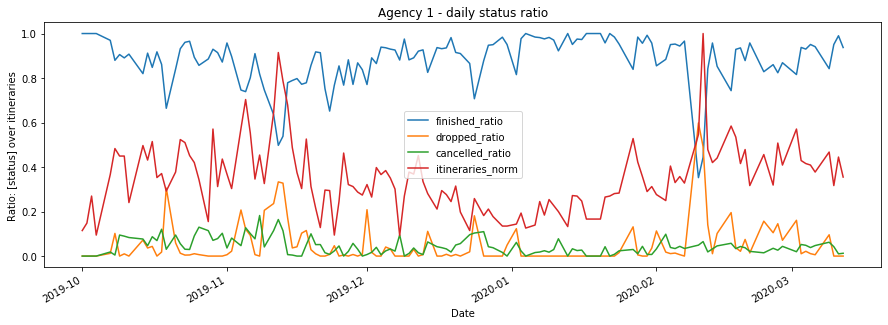

In [26]:
df_a1[working_days][ratios + ['itineraries_norm']].plot(figsize=(15,5));
plt.title('Agency 1 - daily status ratio');
plt.xlabel('Date')
plt.ylabel('Ratio: [status] over itineraries');

The two maximum peaks for itineraries_norm are look correlated with the dropped ones.  
Now we can observe more the itineraries, more the dropped_ratio.
Or more the itineraries, less the finished_ratio.  
[TODO] We need to study what happens with the number of available drivers on each day.

### Day of the week

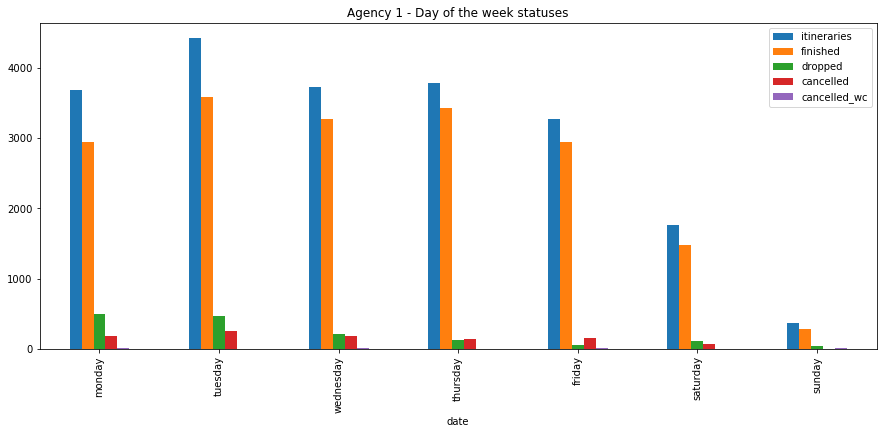

In [27]:
dow = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
# Weekly status
df_a1.groupby(df_a1.index.dayofweek)[status].sum().plot.bar(figsize=(15,6));
plt.xticks(range(len(dow)), dow)
plt.title('Agency 1 - Day of the week statuses');

- The activity level falls on weekends
- There are more activity on first days of the week. May be the service is more used for businesses.

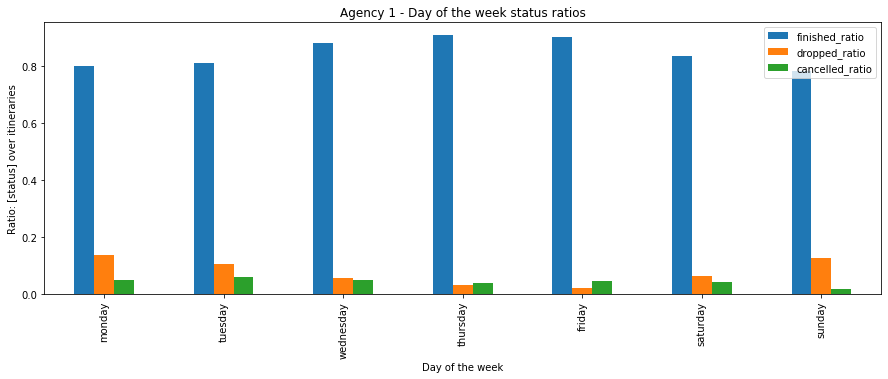

In [28]:
# Day of the week ratios
df_dow = df_a1.groupby(df_a1.index.dayofweek)[status].sum()
selection = ['finished', 'dropped', 'cancelled']
for col in selection:
    # we know min(itineraries) = 1, so we can do this with no worries
    df_dow[col + '_ratio'] = df_dow[col] / df_dow['itineraries']

ratios = [col + '_ratio' for col in selection]
df_dow[ratios].plot.bar(figsize=(15,5));
plt.title('Agency 1 - Day of the week status ratios');
plt.xticks(range(len(dow)), dow)
plt.xlabel('Day of the week')
plt.ylabel('Ratio: [status] over itineraries');

Being monday and tuesday the days with more activity, could be reasonable to see the increment of dropped itineraries on these days, but what it is weird is the increment on dropped intineraries on weekends. Maybe this is related with number of drivers available on weekends.

### Week of of the month

In [29]:
# TODO:

### Let see the correlations

In [30]:
correlate = ['itineraries', 'finished', 'dropped',
             'cancelled', 'finished_ratio', 'dropped_ratio',
             'cancelled_ratio', 'itineraries_norm']

df_a1[working_days][correlate].corr()

,itineraries,finished,dropped,cancelled,finished_ratio,dropped_ratio,cancelled_ratio,itineraries_norm
itineraries,1.000000,0.880585,0.690790,0.672270,-0.592704,0.593160,0.321446,1.000000
finished,0.880585,1.000000,0.294358,0.461246,-0.201070,0.224504,0.191026,0.880585
dropped,0.690790,0.294358,1.000000,0.559674,-0.814642,0.924774,0.247173,0.690790
cancelled,0.672270,0.461246,0.559674,1.000000,-0.563817,0.445071,0.828028,0.672270
finished_ratio,-0.592704,-0.201070,-0.814642,-0.563817,1.000000,-0.856759,-0.394291,-0.592704
dropped_ratio,0.593160,0.224504,0.924774,0.445071,-0.856759,1.000000,0.201181,0.593160
cancelled_ratio,0.321446,0.191026,0.247173,0.828028,-0.394291,0.201181,1.000000,0.321446
itineraries_norm,1.000000,0.880585,0.690790,0.672270,-0.592704,0.593160,0.321446,1.000000


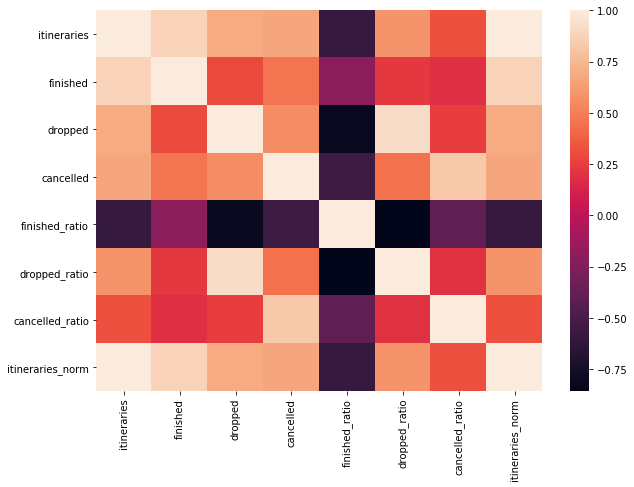

In [31]:
plt.figure(figsize=(10,7))
sns.heatmap(df_a1[working_days][correlate].corr());

We were on the right directions with our assertions.

# Load available driver for comparison

The availabilities table has more than 21 million of records. So we must take care of our queries. The next one is a little intensive one and could require maybe one minute on a local computer. We need the number of drivers available per day for the period in itineraries. This is a way to decrease the number of rows to retrieve (availabilities has data for all the year 2019).

In [32]:
df_it['date'].min().date().strftime('%Y-%m-%d'), df_it['date'].max().date().strftime('%Y-%m-%d')

('2019-10-01', '2020-03-12')

In [33]:
# This is slow but it works
# TODO: we could create this kind of table as views in DB to avoid duplicating cost
df_av = careful_query(
"""
SELECT DATE(sent) as sent, COUNT(1) as messages, COUNT(DISTINCT(driver_id)) as drivers
FROM availabilities
GROUP BY DATE(sent)
HAVING DATE(sent) BETWEEN '{0}' AND '{1}'
""".format(
        df_it['date'].min().date().strftime('%Y-%m-%d'),
        df_it['date'].max().date().strftime('%Y-%m-%d')
    )
, max_cost = 600000)

In [34]:
df_av['date'] = pd.to_datetime(df_av.sent)

In [35]:
df_av.set_index(df_av['date'], inplace=True)

In [36]:
df_av.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2019-10-01 to 2020-03-10
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   sent      161 non-null    object        
 1   messages  161 non-null    int64         
 2   drivers   161 non-null    int64         
 3   date      161 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.3+ KB


In [37]:
# be sure to have the same date index as dataframe for itineraries
df_av.reindex(pd.date_range(df_it['date'].min(), df_it['date'].max()), fill_value="NaN")

,sent,messages,drivers,date
2019-10-01,2019-10-01,69010,2425,2019-10-01
2019-10-02,2019-10-02,74198,2517,2019-10-02
2019-10-03,2019-10-03,73289,2487,2019-10-03
2019-10-04,2019-10-04,69710,2605,2019-10-04
2019-10-05,2019-10-05,40010,1107,2019-10-05
...,...,...,...,...
2020-03-08,2020-03-08,36579,842,2020-03-08
2020-03-09,2020-03-09,95345,3088,2020-03-09
2020-03-10,2020-03-10,102239,3339,2020-03-10
2020-03-11,NaN,NaN,NaN,NaT


In [38]:
df_av.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2019-10-01 to 2020-03-10
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   sent      161 non-null    object        
 1   messages  161 non-null    int64         
 2   drivers   161 non-null    int64         
 3   date      161 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 11.3+ KB


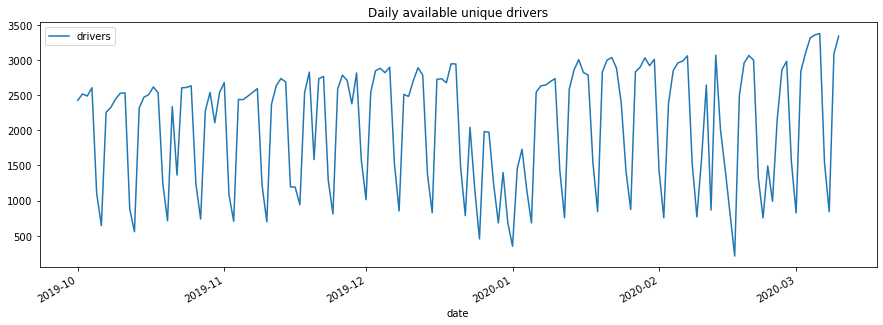

In [39]:
df_av.drivers.plot(figsize=(15,5));
plt.legend()
plt.title('Daily available unique drivers');

Looks like a weekly pattern too and the curves falls on chrismas and new year dates.

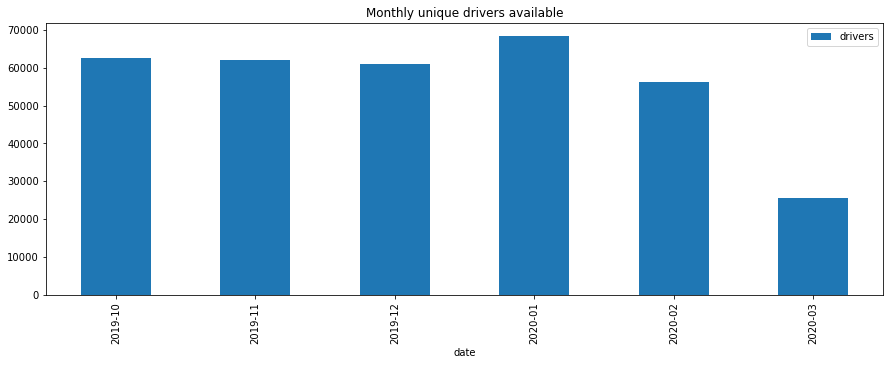

In [40]:
df_av.groupby(df_av.index.to_period('M')).drivers.sum().plot.bar(figsize=(15,5));
plt.legend()
plt.title('Monthly unique drivers available');

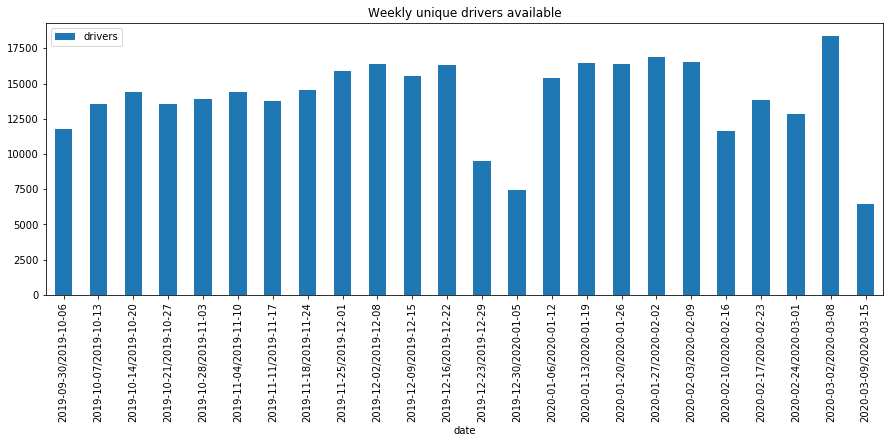

In [41]:
df_av.groupby(df_av.index.to_period('W')).drivers.sum().plot.bar(figsize=(15,5));
plt.legend()
plt.title('Weekly unique drivers available');

In [42]:
# What is the in common interval with data?
min_date = max(df_av.index.min(), df_a1['date'].min())
max_date = min(df_av.index.max(), df_a1['date'].max()) 
min_date, max_date

(Timestamp('2019-10-01 00:00:00'), Timestamp('2020-03-10 00:00:00'))

In [43]:
df = pd.concat([df_av[(df_av.index >= min_date) & (df_av.index <= max_date)],
           df_a1[(df_a1.index >= min_date) & (df_a1.index <= max_date)]], axis=1)

In [44]:
df.isna().sum()

sent                 0
messages             0
drivers              0
date                 0
date                25
agency              25
itineraries         25
finished            25
not_finished        25
dropped             25
cancelled           25
cancelled_wc        25
finished_ratio      25
dropped_ratio       25
cancelled_ratio     25
itineraries_norm    25
dtype: int64

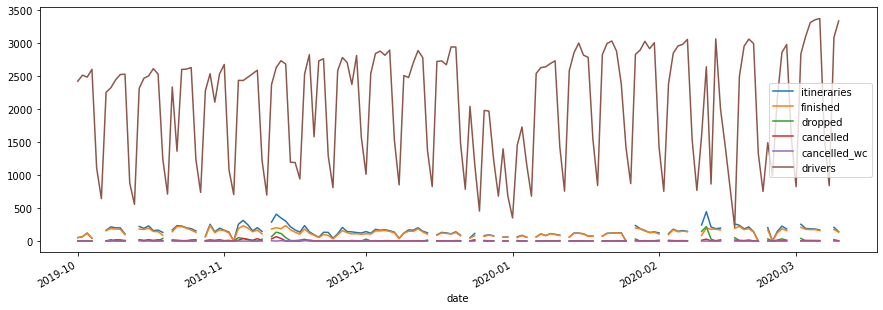

In [45]:
df[status + ['drivers']].plot(figsize=(15,5));

In [46]:
x = df[['drivers']]
x_scaled = min_max_scaler.fit_transform(x)
df['drivers_norm'] = pd.DataFrame(x_scaled).iloc[:,0].tolist()

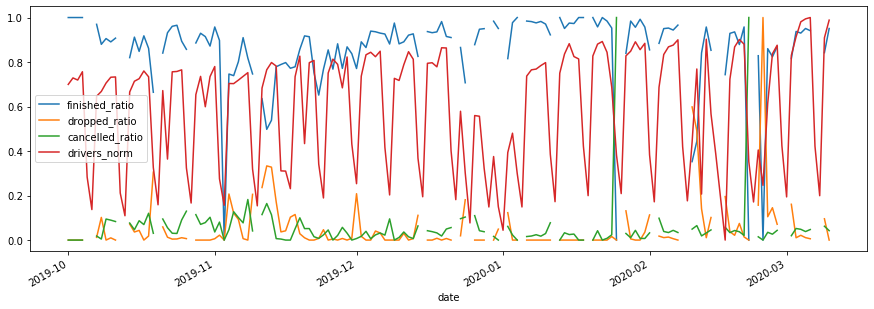

In [47]:
df[ratios + ['drivers_norm']].plot(figsize=(15,5));

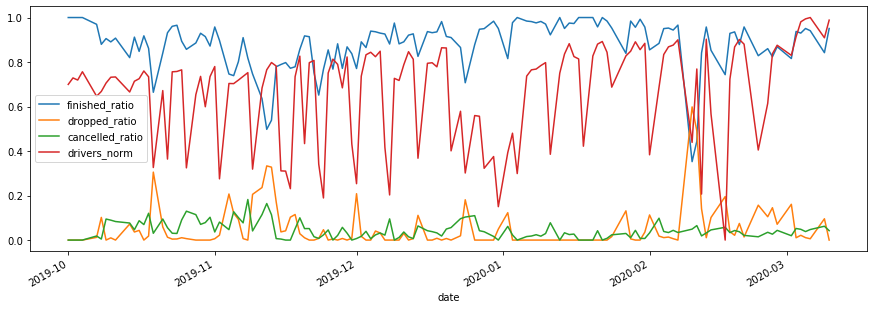

In [48]:
# Lets see what happend on working days
df[df.itineraries > 1][ratios + ['drivers_norm']].plot(figsize=(15,5));

In [49]:
selection = [col for col in df.columns if 'ratio' in col or 'norm' in col]
df[df.itineraries > 1][selection].corr()

,finished_ratio,dropped_ratio,cancelled_ratio,itineraries_norm,drivers_norm
finished_ratio,1.000000,-0.856589,-0.388605,-0.600840,0.290662
dropped_ratio,-0.856589,1.000000,0.195920,0.597783,-0.236775
cancelled_ratio,-0.388605,0.195920,1.000000,0.328087,-0.025926
itineraries_norm,-0.600840,0.597783,0.328087,1.000000,0.198130
drivers_norm,0.290662,-0.236775,-0.025926,0.198130,1.000000


- more the drivers more the finished
- more the drivers more the itineraries (more number of requests then marketing to get drivers?)
- more the drivers less the dropped

In [50]:
df[df.drivers_norm < 0.1]

,sent,messages,drivers,date,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc,finished_ratio,dropped_ratio,cancelled_ratio,itineraries_norm,drivers_norm
date,,,,,,,,,,,,,,,,,
2019-12-25,2019-12-25,20887,455,2019-12-25,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077093
2020-01-01,2020-01-01,18630,351,2020-01-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044234
2020-02-17,2020-02-17,4402,211,2020-02-17,2020-02-17,1.0,261.0,194.0,67.0,51.0,15.0,0.0,0.743295,0.195402,0.057471,0.58427,0.000000


- On christmas and new year dates there were a few drivers available but no itineraries were done.
- 2020-02-17 there were very few drivers available (211), so it is logic to expect a fall in finish ratio an an increment in dropped and cancelled ratios.

We have information with available drivers for dates where there was no itinerary activity.

In [51]:
df[df.agency.isna()]

,sent,messages,drivers,date,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc,finished_ratio,dropped_ratio,cancelled_ratio,itineraries_norm,drivers_norm
date,,,,,,,,,,,,,,,,,
2019-10-05,2019-10-05,40010,1107,2019-10-05,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283096
2019-10-06,2019-10-06,23825,645,2019-10-06,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137125
2019-10-12,2019-10-12,31679,880,2019-10-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211374
2019-10-13,2019-10-13,18417,557,2019-10-13,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.109321
2019-10-20,2019-10-20,31690,713,2019-10-20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158610
2019-10-27,2019-10-27,30583,738,2019-10-27,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166509
2019-11-10,2019-11-10,30955,698,2019-11-10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153870
2019-12-15,2019-12-15,32948,827,2019-12-15,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194629
2019-12-22,2019-12-22,29717,786,2019-12-22,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181675


In [52]:
df[df.agency.isna()].index.dayofweek.value_counts()

6    17
5     6
2     2
Name: date, dtype: int64

We can see that most of the dates with no itinerary activity are Sundays, then Saturday and last one: Tuesday (probably holidays/festive ones)

In [53]:
df[(df.agency.isna()) & (df.index.dayofweek == 2)]

,sent,messages,drivers,date,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc,finished_ratio,dropped_ratio,cancelled_ratio,itineraries_norm,drivers_norm
date,,,,,,,,,,,,,,,,,
2019-12-25,2019-12-25,20887,455,2019-12-25,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077093
2020-01-01,2020-01-01,18630,351,2020-01-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044234


Good intuition we have!

In [54]:
df[(df.agency.isna()) & (df.index.dayofweek == 5)]

,sent,messages,drivers,date,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc,finished_ratio,dropped_ratio,cancelled_ratio,itineraries_norm,drivers_norm
date,,,,,,,,,,,,,,,,,
2019-10-05,2019-10-05,40010,1107,2019-10-05,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.283096
2019-10-12,2019-10-12,31679,880,2019-10-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211374
2020-02-08,2020-02-08,59192,1539,2020-02-08,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.419589
2020-02-15,2020-02-15,46521,1439,2020-02-15,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387994
2020-02-29,2020-02-29,57662,1553,2020-02-29,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.424013
2020-03-07,2020-03-07,61582,1546,2020-03-07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421801


[TODO] Investigate if this were special days

## Test a very simple model to predict dropped using drivers and itineraries

In [55]:
df['DOW'] = df.index.dayofweek

In [56]:
condition = df.itineraries > 1
df_X, df_y = df[condition][['drivers', 'itineraries', 'DOW']], df[condition][['dropped']]
X, y = df_X.to_numpy(), df_y.to_numpy()
dates = df[condition][['drivers', 'itineraries', 'DOW']].index.tolist()

In [57]:
len(X), len(y)

(132, 132)

In [58]:
X_train, X_test = X[:100], X[100:]
y_train, y_test = y[:100], y[100:]
dates_train = dates[:100]
dates_test = dates[100:]

In [59]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [60]:
regr = linear_model.LinearRegression()

In [61]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[-0.00763617  0.22020045 -1.02208424]]


In [63]:
y_pred = regr.predict(X_test)

In [64]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

Mean squared error: 1080.64


In [65]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficient of determination: 0.45


In [66]:
df_pred = pd.DataFrame({'Test': y_test.flatten(), 'Pred': y_pred.flatten()}, index=dates_test)

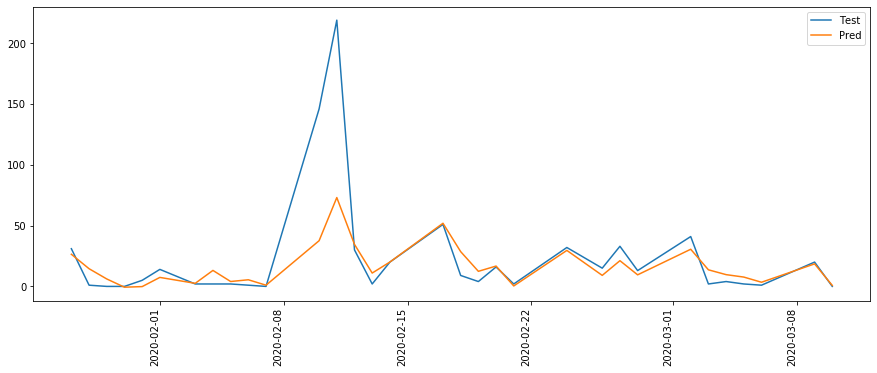

In [67]:
df_pred.plot(figsize=(15,6));
plt.xticks(rotation=90);

**Our simple prediction does not look so bad at all!**

There is a big peak not predicted, but this is just the begining! It is pending look for holidays relations, traffic, etc.